<a href="https://colab.research.google.com/github/Jerry0209/FundamentalLearningEPFL/blob/main/TP9/%5Bexercise%5Dtorch_and_neuralnets_v3_Jerry_Noted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will approach for the first time PyTorch.
First we see how `torch` can help us to avoid long `numpy` code and then we will see how to use `torch` to build a simple neural network for classification.

# Part 1: From Numpy to PyTorch

**What will you learn in this part**:
- Tensors syntax
- Autograd
- Neural Network modules

Let's get back to last week exercise and migrate it to PyTorch. Luckily, the syntax is almost identical. The main difference is that *arrays* are replaced by *tensors*, and all the `np.*` functions become `torch.*`. For more advanced functionalities, we refer you to the [official documentation][torch_doc].

[torch_doc]: https://pytorch.org/docs/stable/index.html

## Single layer MLP in Numpy

Recall the feedforward neural network with a single hidden layer.

![simple_mlp](https://github.com/IdePHICS/FundamentalLearningEPFL/blob/main/TP9/simple_mlp.png?raw=1)

Below is the Numpy implementation of the activations and the feedforward propagation

In [1]:
# Prevent KMP duplicate lib error
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
#

import numpy as np
from typing import Tuple
from numpy.typing import NDArray

def np_sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def np_grad_sigmoid(t):
    """return the derivative of sigmoid on t."""
    return np_sigmoid(t) * (1 - np_sigmoid(t))

def np_mlp( # forward propagation
    x: NDArray[np.float64], w_1: NDArray[np.float64], w_2: NDArray[np.float64]
) -> Tuple[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]]:
    """Feed forward propagation on MLP

    Args:
        x (NDArray[np.float_]): Input vector of shape (d_in,)
        w_1 (NDArray[np.float_]): Parameter matrix of first hidden layer, of shape (d_in, d_hid)
        w_2 (NDArray[np.float_]): Parameter vector of output layer, of shape (d_hid,)

    Returns:
        Tuple[NDArray[np.float], NDArray[np.float], NDArray[np.float]]: Three
            arrays `y_hat`, `z_1`, `z_2`, containing repsectively the output and
            the two preactivations.
    """
    z_1 = w_1.T @ x # matrix multiplication # input vector of single sample point, e.g. MNIST, each image has 784 entries
    # if entire batch, do a different matrix mutiplication
    # w_1 is matrix
    x_1 = np_sigmoid(z_1) #pre-activations
    z_2 = w_2.T @ x_1
    # w_2 is vector?
    y_hat = np_sigmoid(z_2)

    return y_hat, z_1, z_2


And this is the backpropagation with the Mean-squared error loss $\mathcal L (y, \hat y) = \frac{1}{2} \left( y - \hat y \right)^2$:

In [2]:
def np_mlp_backpropagation(
    y: NDArray[np.int_],
    x: NDArray[np.float64],
    w_2: NDArray[np.float64],
    y_hat: NDArray[np.float64],
    z_1: NDArray[np.float64],
    z_2: NDArray[np.float64],
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Do backpropagation and get parameter gradients.

    Args:
        y (NDArray[np.int_]): True label
        x (NDArray[np.float64]): Input data
        w_2 (NDArray[np.float64]): Readout layer parameters
        y_hat (NDArray[np.float64]): MLP output
        z_1 (NDArray[np.float64]): Hidden layer preactivations
        z_2 (NDArray[np.float64]): Readout layer preactivations

    Returns:
        Tuple[NDArray[np.float64], NDArray[np.float64]]: Gradients of w_1 and w_2
    """
    # Feed forward
    _loss = 0.5 * (y - y_hat)**2

    # Backpropogation
    # Try to understand this! One of the most important parts
    delta_2 = (y_hat - y) * np_grad_sigmoid(z_2)
    x_1 = np_sigmoid(z_1)
    dw_2 = delta_2 * x_1
    delta_1 = delta_2 * w_2* np_grad_sigmoid(z_1)
    dw_1 = np.outer(x, delta_1)

    return dw_1, dw_2

Now, we can compute the MLP output and retrieve the gradients

In [3]:
x_np = np.array([0.01, 0.02, 0.03, 0.04])
w_1_np = np.random.randn(4, 5)
w_2_np = np.random.randn(5)

y = 1

y_hat_np, z_1, z_2 = np_mlp(x_np, w_1_np, w_2_np)
dw_1_np, dw_2_np = np_mlp_backpropagation(y, x_np, w_2_np, y_hat_np, z_1, z_2)

print(dw_1_np.shape) # gradient shape same as w_1
print(dw_2_np.shape) # gradient shape same as w_2

(4, 5)
(5,)


This indeed works, but as soon as we change the neural network architecture we have to change our backpropagation function, and keep track of all the computations that involve each parameter. It is a lot of work which we want to delegate to the machine.
This is what *automatic differentiation* does, and libraries like PyTorch implement it.

## Exercise 1

We can manipulate tensors as we want and, by asking for `require_grad=True`, PyTorch handles automatic differentation!

In [4]:
import torch

In [5]:
# EXAMPLE

# Tensor can track gradient
# 'True', each tensor keep its gradient
# We only use Torch array and Torch tensor

a = torch.randn(10, 5) # 10 row, 5 column, input
b = torch.ones(5, requires_grad=True) # Weights

# Note that c is a scalar
c = torch.log(a @ b).sum() # Forward + log loss
print("c", c)
print("c.shape:", c.shape)

# We ask to perform backpropagation #!!
c.backward() # c looks into its gradients to do the backward

print("b.grad:", b.grad)
print("b.grad.shape:", b.grad.shape) # 5, since tensor has 5 entries


c tensor(nan, grad_fn=<SumBackward0>)
c.shape: torch.Size([])
b.grad: tensor([ 3.8643, -1.6504,  1.8334,  3.6805,  2.2720])
b.grad.shape: torch.Size([5])


We now convert the previous code to PyTorch. Autograd is responsible of keeping track of each element in the computations, so we only need to implement the forward pass!

In [6]:
def sigmoid(t) -> torch.FloatTensor:
    """apply sigmoid function on t."""
    # Look at Pytorch document
    #vvvvv YOUR CODE HERE vvvvv#˙
    return 1.0/(1 + torch.exp(-t))

    #^^^^^^^^^^^^^^^^^^^^^^^^^^#

def mlp(
    x: torch.Tensor, w_1: torch.Tensor, w_2: torch.Tensor
) -> torch.Tensor:
    """Feed forward propagation on MLP

    Args:
        x (torch.Tensor): Input vector of shape (d_in,)
        w_1 (torch.Tensor): Parameter matrix of first hidden layer, of shape (d_in, d_hid) !!
        w_2 (torch.Tensor): Parameter vector of output layer, of shape (d_hid,) !!

    Returns:
        torch.Tensor: Network output
    """
    #vvvvv YOUR CODE HERE vvvvv# !! Different from before

    z_1 = w_1.T @ x
    x_1 = sigmoid(z_1)
    z_2 = w_2.T @ x_1
    y_hat = sigmoid(z_2)

    #^^^^^^^^^^^^^^^^^^^^^^^^^^#

    return y_hat

Now, we can verify that the output corresponds to the numpy implementation

In [7]:
# Compare manual result and Pytorch Result
# Inputs are tensor, so you have to convert np array to tensors
#vvvvv YOUR CODE HERE vvvvv#

# Convert arrays to tensors. Mind that we will ask for parameters gradients!
x = torch.tensor(x_np)
w_1 = torch.tensor(w_1_np, requires_grad=True)
w_2 = torch.tensor(w_2_np, requires_grad=True)

y_hat = mlp(x, w_1, w_2) # Foward

#^^^^^^^^^^^^^^^^^^^^^^^^^^#
loss = 0.5 * (y - y_hat)**2 # Loss
#Now perform backpropagation
loss.backward() # Back propagation
#^^^^^^^^^^^^^^^^^^^^^^^^^^#

print(np.allclose(w_1.grad.numpy(), dw_1_np)) # convert into numpy to compare
print(np.allclose(w_2.grad.numpy(), dw_2_np))


True
True


C:\Users\Jerry\AppData\Local\Temp\ipykernel_28388\4269426822.py:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  z_2 = w_2.T @ x_1


## Exercise 2.1

Computing gradients has now got much easier! :grin:

Still, PyTorch provides an even easier interface to build and train neural networks, whose components are in the `torch.nn` module.
The main tool is the `torch.nn.Module` class, from which all neural networks shall inherit. This must implement a `forward` method, and, if needed, declare its parameters in the `__init__` method.

Let's convert our MLP to a proper Module

In [8]:
class MLP(torch.nn.Module): # inherit
    def __init__(self, dim_in: int, dim_hidden: int) -> None: # Object oriented programming, parameters here
        #vvvvv YOUR CODE HERE vvvvv# !! TA's
        super().__init__()
        self.w_1 = torch.nn.Parameter( # define the matrix
            torch.randn(dim_in, dim_hidden, requires_grad=True)
        )
        self.w_2 = torch.nn.Parameter(
            torch.randn((dim_hidden, 1), requires_grad=True)
        )


        #^^^^^^^^^^^^^^^^^^^^^^^^^^#

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #vvvvv YOUR CODE HERE vvvvv#

        z_1 = self.w_1.T @ x # Matrix multipilication
        x_1 = z_1.sigmoid()
        z_2 = self.w_2.T @ x_1

        return z_2.sigmoid()

        #^^^^^^^^^^^^^^^^^^^^^^^^^^#

Even better, `torch.nn` comes with a lot of layers and functions which are ready to use.

For instance, we have a `torch.sigmoid` function, as well as `torch.nn.Linear` layer and a `torch.nn.MSELoss` loss.

Here is a minimal implementation of our forward and backward pass:

In [9]:
from torch import nn

class MyMLP(nn.Module):
    def __init__(self, dim_in: int, dim_hidden: int) -> None:
        super().__init__()

        # NOTE: Linear has a `bias` term by default!
        self.linear1 = nn.Linear(dim_in, dim_hidden, bias=False)
        self.linear2 = nn.Linear(dim_hidden, 1, bias=False)

    def forward(self, x): ## Iteration through layers
        x = self.linear1(x).sigmoid()
        return self.linear2(x).sigmoid()

Now initialize your model and compute the gradients with respect to the MSE loss

In [10]:
DIM_IN = 5
DIM_HIDDEN = 10

x = torch.ones(DIM_IN)
y = torch.tensor([0.1])

#vvvvv YOUR CODE HERE vvvvv#

my_mlp = MyMLP(DIM_IN, DIM_HIDDEN)
print(my_mlp)
## my_mlp is the output??

loss = nn.MSELoss()
loss(y, my_mlp(x)).backward()


#^^^^^^^^^^^^^^^^^^^^^^^^^^#

MyMLP(
  (linear1): Linear(in_features=5, out_features=10, bias=False)
  (linear2): Linear(in_features=10, out_features=1, bias=False)
)


## Exercise 2.2


Check the sizes of the gradients of each layer and verify that they correspond to what you expect.

In [11]:
#vvvvv YOUR CODE HERE vvvvv#

# Note that we have multiple ways to retrieve the parameters
gw_1 = my_mlp.linear1.get_parameter('weight')
gw_2 = my_mlp.linear2.get_parameter('weight')
print(gw_1.shape)
print(gw_2.shape)

#^^^^^^^^^^^^^^^^^^^^^^^^^^#

torch.Size([10, 5])
torch.Size([1, 10])


## One more thing...

The `nn.Sequential` module stacks the given layer one after the other.
Still, to get more control on the forward, it is better to stick to self-defined module

In [12]:
sequential_mlp = nn.Sequential( # Create Block
    nn.Linear(DIM_IN, DIM_HIDDEN, bias=False),
    nn.Sigmoid(),
    nn.Linear(DIM_HIDDEN, 1, bias=False),
    nn.Sigmoid(),
)

print(sequential_mlp)

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=False)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=False)
  (3): Sigmoid()
)


# Part 2: Hands on MNIST

**What you will learn in the second part**: This lab serves as an introduction to PyTorch. We will learn the different steps required in training a deep learning model with modern libraries, such as PyTorch.

So, which are these steps?

* Preliminaries:
    * load the train and test datasets, `train_dataset` and `test_dataset` (MNIST in our case)
    * turn the datasets into a "dataloaders": `train_dataloader` and `test_dataloader`
    * define your `model` architecture
    * define your `optimizer`, e.g. SGD


* Training: Now we have all the building blocks and we need to make our model "learn". In most cases, the training follows a specific "recipe". Specifically, we feed the `model` the whole `train_dataset` using batches that come from the `train_dataloader`. We repeat this a certain number of times, called `epochs`. Each epoch consists of `batches`. So what do we do for each batch?
    * zero out the optimizer. In essence we prepare the optimizer for the incoming data
    * compute the output of the model $f(\cdot)$ for our current data: $x\mapsto f(x)$
    * compute the loss: $\mathcal{L}(f(x), y)$ where $y$ denotes the ground truth
    * perform the `backpropagation` algorithm which involves computing the gradients and performing the update rule



## Getting the preliminaries out of the way

In [13]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader ## Crucial Components

We now load the datasets. We are going to work with MNIST and our goal is classify digits. This is a popular dataset and PyTorch offers it out-of-the-box, making our life easy! We simply need to call the corresponding method.

In [14]:
# The data are given as PIL images. We need to convert our data to a type
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform"
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.1307,), (0.3081,)) ## In practice, we may want to stack differnt (steps)? We need normalization
])

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

In [15]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01

# find out which device is available
def device_type():
    if torch.cuda.is_available(): # GPU
        return 'cuda'
    elif torch.backends.mps.is_available(): # GPU, Apple Silicon
        return 'mps'
    else:
        return 'cpu'
DEVICE = torch.device(device_type())
print(DEVICE)


# Change runtime type

cuda


However, we cannot use the whole dataset; it is too large for computers to handle. Instead, we perform *stochastic* gradient descent, i.e. we feed the model part of the data called batches. In order to do so, we use Pytorch DataLoaders.

In [16]:
# Construct the dataloader for the training dataset.
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, # which dataset to use
    batch_size=BATCH_SIZE, # in one gradient computation
    shuffle=True, ## ? not so important, when do computation again, maybe you don't want the same batches and same order?
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)


Now, let's visualize some samples.

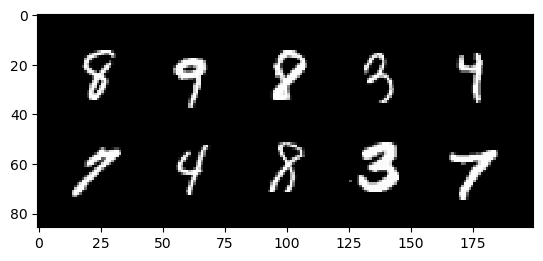

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 10 images of the train dataset.
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

## Exercise 3
Now, we are ready to define our model. We will start with a simple model, a MultiLayer Perceptron (MLP) with 2 layers.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        # define the different modules of the network
        super().__init__()
        # How many features should our model have?
        self.fc1 = nn.Linear(784, 50) # input 784, hidden 50

        # How many outputs should our model have?
        self.fc2 = nn.Linear(50, 10) # 10 outputs, 0 - 9
        # we also define the non-linearity
        self.relu = nn.ReLU() # ? why



    def forward(self, x: torch.Tensor) -> torch.Tensor: ## how to do this?
        # ***************************************************
        # INSERT YOUR CODE HERE
        # You should (a) transform the input to a size that is readable
        # by the MLP and (b) pass the input x successively
        # through the layers.
        # ***************************************************
        # transform the image to a vector

        # view is very important
        # create tensor but do not cost memory, do not create a copy of the tensor, used to reshape the tensor

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # pass the vectored image through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)


        return x


In [19]:
# initialize the model
model = Net() # defined in previous

# move model to device
model = model.to(DEVICE) #  Maybe put into GPU

# define the optimizer in order to train the model
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

We now define:
* the `fit` function that performs the training part
* the `predict` function that takes as input the test dataloader and prints the performance metrics (e.g. accuracy)

In [20]:
def train_epoch( # 1 epoch -> go through all the dataset
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load a single batch and zero the optimizer.
    Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() # clear gradients from previous step

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target) # same as logistic for binary, generalization to more parameters

        # compute the gradients
        loss.backward()


        # perform the gradient step
        optimizer.step() # SGD

        # print statistics
        running_loss += loss.item() # convert tensor number to py number

    return running_loss / len(train_dataloader.dataset) # mean loss in the batch


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

    return losses

In [21]:
def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # no training! don't change gradient at test data
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data) # compute the output
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset) # percentage of the correct prediction

    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')


We perform a "sanity check". Our model is at the moment initialized randomly and we have 10 classes (each class has approximately the same number of samples). This means that we should get random performance -> ~10% accuracy.

In [22]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE) # if not trained, model output should give you similar number of samples in each category

Test set: Avg. loss: 0.0012, Accuracy: 1100/10000 (11%)


In [23]:
# train for 20 epochs
losses = fit(
    model=model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

Epoch 0: Loss=0.0022083257873853047
Epoch 1: Loss=0.0020859604676564535
Epoch 2: Loss=0.0019352647980054219
Epoch 3: Loss=0.0017576886475086212
Epoch 4: Loss=0.0015693804959456127
Epoch 5: Loss=0.001390125972032547
Epoch 6: Loss=0.0012324718356132506
Epoch 7: Loss=0.001100387672583262
Epoch 8: Loss=0.0009923132201035817
Epoch 9: Loss=0.0009047642598549525
Epoch 10: Loss=0.0008338202019532522
Epoch 11: Loss=0.0007756961365540823
Epoch 12: Loss=0.0007273959219455719
Epoch 13: Loss=0.0006870660781860352
Epoch 14: Loss=0.0006528372675180435
Epoch 15: Loss=0.000623507700363795
Epoch 16: Loss=0.0005982037087281545
Epoch 17: Loss=0.000575944721698761
Epoch 18: Loss=0.0005566822558641434
Epoch 19: Loss=0.0005389724274476369


Let's visualize the loss progression.

Text(0.5, 1.0, 'Loss progression across epochs')

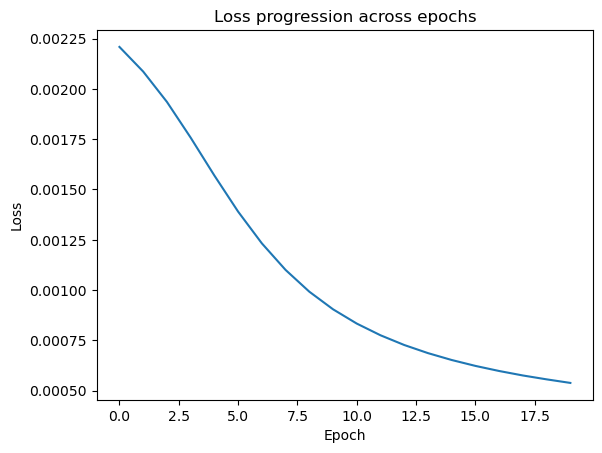

In [24]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs") # it should decrease

In [25]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0003, Accuracy: 8755/10000 (88%)


The results are not very good. There are some major problems. We see from the plot above that the loss keeps dropping and does not "plateau". This indicates that we can run the optimization a few more epochs and improve the performance. Another point is that our learning rate is too slow or the selection of vanilla SGD as our optimizer is not optimal. In the next section we will see that simply changing the optimizer (from SGD to Adam) yields very different results!

## Exercise 4: CNN

## Evaluated Part

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__() 
        # ************ YOUR CODE HERE ************
        # define a CNN with 2 convolutional layers, followed by ReLU and Maxpool each
        
        # 2D Convolution: class torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        # and a fully connected layer at the end.
        # Hint: you could use nn.Sequential() for the convolutional part

        self.conv_layers = nn.Sequential( # convolutional part doesn't consider the size of the entire image, since it's local
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3), # first conv layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # first maxpool, move the window by 2 each time, while increasing the channels, reduce spatial dimension
            nn.Conv2d(16, 32, 3), # second conv layer
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # second maxpool
        )

        self.fc1 = nn.Linear(32 * 5 * 5, 120) # Only need to change this line according to the output size of conv layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 numbers, among 0-9, which one has the highest probability



    def forward(self, x):
        # ************ YOUR CODE HERE ************
        x = self.conv_layers(x) # pass through conv layers
        x = torch.flatten(x, 1) # flatten all dimensions
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x #!!!!! don't forget to return x!!!



In [27]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer. Use Adam
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=15,
    device=DEVICE
)

Epoch 0: Loss=0.0005339288411041101
Epoch 1: Loss=7.311777217934528e-05
Epoch 2: Loss=4.7977319390823446e-05
Epoch 3: Loss=3.8024039193987845e-05
Epoch 4: Loss=3.117268248461187e-05
Epoch 5: Loss=2.4959569967662293e-05
Epoch 6: Loss=2.0321610461299618e-05
Epoch 7: Loss=1.6720738797448575e-05
Epoch 8: Loss=1.8593065704529484e-05
Epoch 9: Loss=1.5099293909346063e-05
Epoch 10: Loss=1.1100454585781942e-05
Epoch 11: Loss=1.1036441995141407e-05
Epoch 12: Loss=9.750268563705806e-06
Epoch 13: Loss=1.0048323446729531e-05
Epoch 14: Loss=7.280987131525762e-06


In [28]:
# How does the CNN perform compared to the MLP?
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0000, Accuracy: 9889/10000 (99%)


Based on the results shown in the screenshot, the CNN perform significantly better than the MLP model we likely saw earlier. The test accuracy reached an impressive 99%, which means the model correctly predicted 9908 out of 10000 images. Usually, a simple MLP struggles to get past 97% or 98% on this type of dataset because it is not optimized for image data, so reaching 99% is a very strong result.

Looking at the training graph, we can see that the learning process was very smooth. The loss dropped rapidly in the first few epochs and continued to go down steadily without any big spikes. By the end of epoch 14, the loss was extremely low, around 7.8e-06, and the average test loss is listed as 0.0000. This suggests the model has learned the dataset almost perfectly and is very confident in its predictions.

The main reason for this performance gap is how the two models handle the input. The MLP flatten the 2D image into a long vector, which destroys the spatial relationships between pixels. However, the CNN preserves the 2D structure and use convolutional filters to detect local features like edges and curves. This ability to understand the spatial layout helps the CNN achieve much higher accuracy compared to the MLP.

Text(0.5, 1.0, 'Loss progression across epochs')

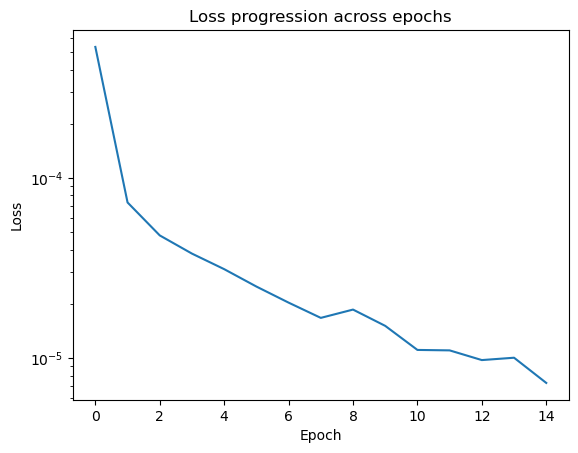

In [29]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

# Part 3: To go further: play with CIFAR10

MNIST is a fairly simple dataset. What happens in more challenging datasets? Try to train a network on CIFAR10 dataset and see how it performs. You can use the same code as above, but you need to change the model architecture.

In [30]:
#--- Load all the necessary libraries ---#
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader ## Crucial Components


# Convert our data to a type that is readable by a Neural Network by ToTensor() "transform"
transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.1307,), (0.3081,)) 
])

# load the train dataset
train_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)



#--- define the hyperparameters ---#
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01



#--- find out which device is available ---#
def device_type():
    if torch.cuda.is_available(): # GPU
        return 'cuda'
    elif torch.backends.mps.is_available(): # GPU, Apple Silicon
        return 'mps'
    else:
        return 'cpu'
DEVICE = torch.device(device_type())
print(DEVICE)

cuda


In [31]:
#--- Construct the dataloader for the training dataset. ---#

# Shuffle the data to promote stochasticity.
train_dataloader_CIFAR10 = torch.utils.data.DataLoader(
    dataset=train_dataset_CIFAR10, # which dataset to use
    batch_size=BATCH_SIZE, # in one gradient computation
    shuffle=True, ## ? not so important, when do computation again, maybe you don't want the same batches and same order?
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader_CIFAR10 = torch.utils.data.DataLoader(
    dataset=test_dataset_CIFAR10,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

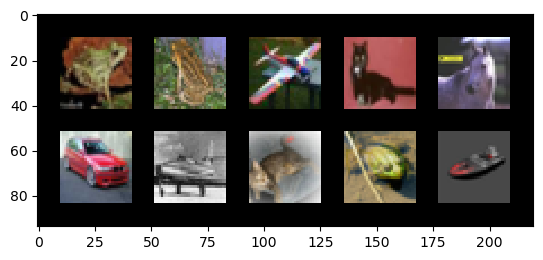

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 10 images of the train dataset.
images = next(iter(train_dataloader_CIFAR10))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

In [33]:
#--- Define train_epoch & fit & predict ---#

def train_epoch( # 1 epoch -> go through all the dataset
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load a single batch and zero the optimizer.
    Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() # clear gradients from previous step

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target) # same as logistic for binary, generalization to more parameters

        # compute the gradients
        loss.backward()


        # perform the gradient step
        optimizer.step() # SGD

        # print statistics
        running_loss += loss.item() # convert tensor number to py number

    return running_loss / len(train_dataloader.dataset) # mean loss in the batch


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

    return losses


def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # no training! don't change gradient at test data
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data) # compute the output
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset) # percentage of the correct prediction

    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')

In [39]:
#--- Define CNN for CIFAR-10 ---#

class CNN_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__() 

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), # first conv layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # first maxpool
            nn.Conv2d(16, 32, 3), # second conv layer
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # second maxpool
        )

        self.fc1 = nn.Linear(32 * 6 * 6, 120) # Only need to change this line according to the output size of conv layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 numbers, among 0-9, which one has the highest probability



    def forward(self, x):
        # ************ YOUR CODE HERE ************
        x = self.conv_layers(x) # pass through conv layers
        x = torch.flatten(x, 1) # flatten all dimensions
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x #!!!!! don't forget to return x!!!

#--- CNN with deeper layers & batch normalization & dropout ---#
# class CNN_CIFAR10(nn.Module):
#     def __init__(self):
#         super().__init__() 

#         self.conv_layers = nn.Sequential( 
#             nn.Conv2d(3, 32, 3, padding=1), # first conv layer, 3 input channels for RGB
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # first maxpool

#             nn.Conv2d(32, 64, 3, padding=1), # second conv layer
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # second maxpool

#             nn.Conv2d(64, 128, 3, padding=1), # Deeper layer with more channels
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)     
#         )

#         self.fc1 = nn.Linear(128 * 4 * 4, 512) # Only need to change this line according to the output size of conv layers
#         self.fc2 = nn.Linear(512, 84)
#         self.dropout = nn.Dropout(0.5) # To prevent overfitting
#         self.fc3 = nn.Linear(84, 10) # 10 classes in CIFAR-10



#     def forward(self, x):
#         x = self.conv_layers(x) # pass through conv layers
#         x = torch.flatten(x, 1) # flatten all dimensions
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x 

In [40]:
#--- Initialize model and predict before training ---#
cnn_cifar10 = CNN_CIFAR10().to(DEVICE)

predict(model=cnn_cifar10, test_dataloader=test_dataloader_CIFAR10, device=DEVICE) # Model output should give you similar number of samples in each category, since not trained yet

Test set: Avg. loss: 0.0012, Accuracy: 892/10000 (9%)


In [41]:
# Define the optimizer. Use Adam
optimizer = optim.Adam(cnn_cifar10.parameters(), lr=LEARNING_RATE)

# train the CNN
losses = fit(
    model=cnn_cifar10,
    train_dataloader=train_dataloader_CIFAR10,
    optimizer=optimizer,
    epochs=15,
    device=DEVICE
)

Epoch 0: Loss=0.0019458911561965942
Epoch 1: Loss=0.0015607950949668883
Epoch 2: Loss=0.0013812945127487182
Epoch 3: Loss=0.0012548410844802856
Epoch 4: Loss=0.0011815528321266174
Epoch 5: Loss=0.0011444037842750548
Epoch 6: Loss=0.0010764249563217163
Epoch 7: Loss=0.0010246068036556244
Epoch 8: Loss=0.0010039321947097777
Epoch 9: Loss=0.0009757736885547638
Epoch 10: Loss=0.0009432718324661255
Epoch 11: Loss=0.0009030846750736237
Epoch 12: Loss=0.0008797676742076873
Epoch 13: Loss=0.0008539199411869049
Epoch 14: Loss=0.0008108063983917237


Text(0.5, 1.0, 'Loss progression across epochs')

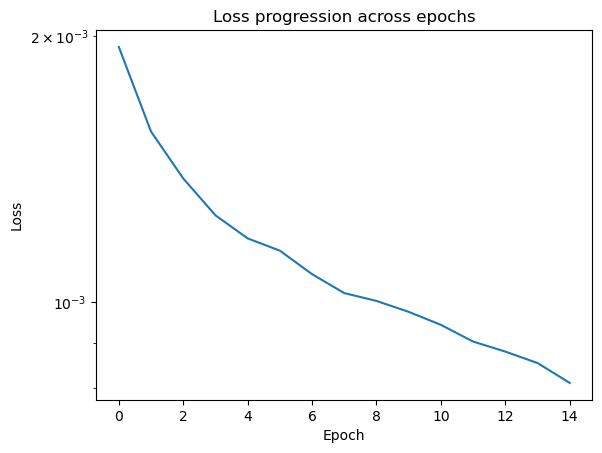

In [42]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Loss progression across epochs")

In [43]:
#--- Evaluate the CNN after training on CIFAR-10 ---#
predict(model=cnn_cifar10, test_dataloader=test_dataloader_CIFAR10, device=DEVICE)

Test set: Avg. loss: 0.0006, Accuracy: 6186/10000 (62%)
